# Neural Processes - PyTorch implementation

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
class NP(torch.nn.Module):
    def __init__(self, n_features, n_labels, z_dim, h_specs, g_specs):
        """Defines the attributes, i.e. the modules that define the 
           operation needed to implement the Neural Process
           
            Inputs:
                n_features: number of features per observation, i.e. number of 
                            components of vector `x_i`, i = 1, ..., n
                
                n_labels: number of components of the output vector `y_i`
                            i = 1, ..., n
                
                z_dim: dimension of the latent `z` vector
                
                h_specs: list of tuples defining the number of units and activation
                            functions per each layer of the encoder. The size of the 
                            `r` representation must be passed as last tuple. If no 
                            activation is needed put `None`; 
                            e.g. two layers with 8 hidden units and relu activation 
                            function, output layer is linear:
                                [(8, torch.nn.ReLU()), (8, torch.nn.ReLU()), (r_dim, None)]
                
                g_specs: list of tuples defining the number of units and activation
                            functions per each layer of the decoder. The size of the 
                            If no activation is needed put `None`; The size of the 
                            output layer, i.e. the number of components of the `y_target` 
                            must agree with the dimension of `y_context`
                            e.g. two layers with 8 hidden units and relu activation 
                            function, output layer is linear:
                                [(8, torch.nn.ReLU()), (8, torch.nn.ReLU()), (y_context_dim, None)]
                                
            
            Returns:
                y_hat: the predicted value for `y_target` based on `z` and `x_target`
                
               
           """
        super().__init__()
        self.n_features = n_features 
        self.n_labels = n_labels
        self.z_dim = z_dim #number of components of z
        self.h_specs = h_specs
        self.g_specs = g_specs
        self.h() #call the h() method in the constructor to modules for the layers
        self.r_to_z() #call the r_to_z() method in the constructor to add module that maps r -> (z_mu, z_logvar)  
        self.g() #call the g() method in the constructor to modules for the layers
            
    def h(self):
        """Function that dynamically creates attributes for 
           the encoder network `h()`; needs to be run in the 
           constructor; check that every layer is defined by
           accessing the OrderedDict in object._modules"""
        h_input_dim = self.n_features + self.n_labels #number of features + output per observation
        
        for i in range(len(self.h_specs)):
            if i == 0:    
                setattr(self, 'h_layer' + str(i), torch.nn.Linear(h_input_dim, self.h_specs[i][0]))
                if self.h_specs[i][1]:
                    setattr(self, 'h_layer' + str(i) + '_act', self.h_specs[i][1])
            else:
                setattr(self, 'h_layer' + str(i), torch.nn.Linear(self.h_specs[i-1][0], self.h_specs[i][0]))
                if self.h_specs[i][1]:
                    setattr(self, 'h_layer' + str(i) + '_act', self.h_specs[i][1])  
        return
                   
                
    def aggregate(self, x):
        """Computes the mean of the elements in the r_i 
           tensor created by `h()`; not called in the 
           constructor, it is simply called in the `forward()`
           method; it takes the mean along columns of the tensor"""
        return torch.mean(x, dim=0)
    
    
    def r_to_z(self):
        """Function that creates attributes in for the 
           mapping function r -> (z_mean, z_logvar)"""
        setattr(self, 'r_to_mean', torch.nn.Linear(self.h_specs[-1][0], self.z_dim)) # self.h_specs[-1][] since r_dim is in the last tuple
        setattr(self, 'r_to_logvar', torch.nn.Linear(self.h_specs[-1][0], self.z_dim))
        setattr(self, 'r_to_logvar_softplus', torch.nn.Softplus())
        return
    
    
    def sample_z(self, z_mean, z_logvar):
        """Function used to sample from z using the 
           reparametrization 
               z = z_mean + exp(1/2 * z_logvar) * eps
           where eps ~ N(0, I)"""
        var = torch.exp(0.5 * z_logvar)
        eps = torch.randn_like(var) 
        z_sample = eps.mul(var).add_(z_mean)
        z_sample = z_sample.unsqueeze(-1) # from [[1,2,3]] to [[1], [2], [3]]
        return z_sample

    
    def g(self):
        """Function that dynamically creates attrbutes for 
           the decoder network `g()`; needs to be run in the 
           constructor; check that every layer is defined by
           accessing the OrderedDict in object._modules"""
        g_n_features = self.n_features + self.z_dim #number of features
        
        for i in range(len(self.g_specs)):
            if i == 0:    
                setattr(self, 'g_layer' + str(i), torch.nn.Linear(g_n_features, self.g_specs[i][0]))
                if self.g_specs[i][1]:
                    setattr(self, 'g_layer' + str(i) + '_act', self.g_specs[i][1])
            else:
                setattr(self, 'g_layer' + str(i), torch.nn.Linear(self.g_specs[i-1][0], self.g_specs[i][0]))
                if self.g_specs[i][1]:
                    setattr(self, 'g_layer' + str(i) + '_act', self.g_specs[i][1])    
                
    
    def forward(self, xy_context, x_target=None):
        """Opearations to be implemented at each forward pass;
           the modules to be used are already build in the 
           constructor, just call them accessing the `_modules`
           attributes"""

        # from context data to r_i
        r_i = xy_context
        for layer_name, layer_func in self._modules.items():
            if layer_name.startswith('h'):
                r_i = layer_func(r_i)
                
        # from r_i's to r
        r = self.aggregate(r_i)
        
        # from r to z_mean and z_logvar
        z_mean = self._modules['r_to_mean'](r)
        z_logvar = self._modules['r_to_logvar_softplus'](self._modules['r_to_logvar'](r))
        
        # sample z from the distribution
        z_sample = self.sample_z(z_mean, z_logvar)
        
        # concatenate x_target and z
        xz = torch.cat([x_target, z_sample.view(z_sample.shape[1], z_sample.shape[0]).expand(x_target.shape[0], -1)], dim=1)
        y_target = xz
        for layer_name, layer_func in self._modules.items():
            if layer_name.startswith('g'):
                y_target = layer_func(y_target)
        
        return y_target, z_sample

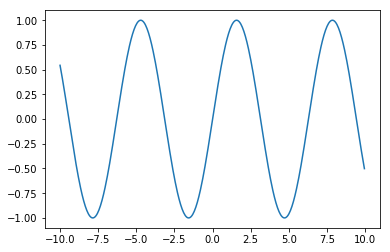

In [63]:
all_x_np = np.arange(-10, 10, 0.05).reshape(-1, 1).astype(np.float32)
all_y_np = np.sin(all_x_np)
#print(' x \t\t y \n', np.concatenate((all_x_np, all_y_np), axis=1))

plt.plot(all_x_np,all_y_np)
plt.show()

In [81]:
x_c = torch.from_numpy(all_x_np[:100])
x_t = torch.from_numpy(all_x_np[100:])
y_c = torch.from_numpy(all_y_np[:100])
y_t = torch.from_numpy(all_y_np[100:])
# print('\tx_c \t\t y_c \n', torch.cat([x_c, y_c], dim=1))

In [139]:
r_dim = 3
z_dim = 10
h_specs = [(5, torch.nn.ReLU()), (10, torch.nn.ReLU()), (5, torch.nn.ReLU()), (r_dim, None)]
g_specs = [(5, torch.nn.ReLU()), (5, torch.nn.ReLU()), (x_t.shape[1], None)]

model = NP(n_features=x_c.shape[1], n_labels=y_c.shape[1], h_specs=h_specs, z_dim=z_dim, g_specs=g_specs)

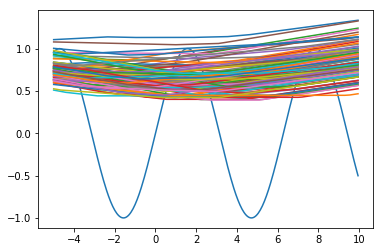

In [140]:
# for i in range(y_hat.shape[1]):
plt.plot(x_t.data.numpy(), y_t.data.numpy())
for i in range(100):
    i+=1
    y_hat, z_sample = model(torch.cat([x_c, y_c], dim=1), x_t)
    plt.plot(x_t.data.numpy(), y_hat.data.numpy())
plt.show()

In [141]:
# epochs = 10000
# criterion = torch.nn.L1Loss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimizer.zero_grad()

# for epoch in range(epochs):
#     epoch += 1
    
#     # Train step
#     model.train()
#     y_hat, z_sample = model(torch.cat([x_c, y_c], dim=1), x_t)
#     loss = criterion(y_hat, y_t)
#     loss.backward()
#     optimizer.step()

#     # Eval
#     model.eval()
#     with torch.no_grad():
#         y_hat, z_sample = model(torch.cat([x_c, y_c], dim=1), x_t)


#     # Vis
#     if epoch % 1000 == 0:
#         fig, ax = plt.subplots()
#         ax.plot(x_t.data.numpy(), y_hat.data.numpy(), ".", label="pred")
#         ax.plot(x_t.data.numpy(), y_t.data.numpy(), ".", label="data")
#         ax.set_title(f"MSE: {loss.item():0.1f}")
#         ax.legend()
#         print('epoch: {}, loss: {}'.format(epoch, loss.item()))